## test+train的Fat data全用來當word2vec的訓練文本
## 不考慮出現"not"的情況( "not" 在model中相關字的意思和"not"沒有太大相關性)

In [1]:
from os import listdir
from os.path import isfile, isdir, join
from collections import Counter
import csv
import numpy
import pandas as pd
from gensim.models.word2vec import Word2Vec
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


from data_preprocess import content_fraction
from Dataloader import dataloader

In [2]:
train_data_path = "..\Case_Presentation_1_Data\Train_Textual\\"
test_data_path  = "..\Case_Presentation_1_Data\Test_Intuitive\\"

train_data = dataloader(train_data_path)
test_data  = dataloader(test_data_path)

In [3]:
print(train_data.text_list[0])

['discharg', 'summari', 'unsign', 'admiss', 'date', 'report', 'statu', 'unsign', 'discharg', 'date', 'discharg', 'diagnosi', 'coronari', 'arteri', 'diseas', 'unstabl', 'angina', 'histori', 'present', 'ill', 'hoopl', 'old', 'woman', 'statu', 'post', 'doubl', 'coronari', 'arteri', 'bypass', 'graft', 'endarterectomi', 'fourteen', 'year', 'ago', 'develop', 'angina', 'six', 'month', 'ago', 'suffer', 'unstabl', 'angina', 'sever', 'day', 'coronari', 'catheter', 'result', 'show', 'sever', 'occlus', 'saphen', 'vein', 'graft', 'occlus', 'left', 'anterior', 'descend', 'echocardiogram', 'show', 'excel', 'left', 'ventricular', 'function', 'intraaort', 'balloon', 'pump', 'place', 'reliev', 'intract', 'angina', 'past', 'medic', 'histori', 'signific', 'chest', 'pain', 'short', 'breath', 'admit', 'talc', 'commun', 'medic', 'center', 'catheter', 'coronari', 'arteri', 'bypass', 'graft', 'coronari', 'endarterectomi', 'no', 'chest', 'pain', 'six', 'month', 'prior', 'admiss', 'time', 'inder', 'aspirin', 'si

### 取train data和test data中"非肥胖"的text

In [4]:
model = Word2Vec(test_data.text_list[200:400])

In [5]:
#定義相關性
def similar(w2v_model, word, target, topn=10):
        try:
            return w2v_model.wv.similarity(word, target)
        except:
            return 0

In [6]:
#找和 words相關性最大的前 [topn] 個字
def most_similar(w2v_model, words, topn=20):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df

### 和"not"相關的前幾個字和"not"本身文義不相關

In [7]:
print(most_similar(model, ["not"]))

                   not       cos
0                 none  0.911686
1   treatmentsprocedur  0.908952
2             procedur  0.896722
3                brief  0.889055
4                 oper  0.884970
5               detail  0.872446
6              remaind  0.849847
7              uncompl  0.848976
8               cather  0.846359
9               hospit  0.841378
10               cours  0.838909
11              stress  0.820454
12               resum  0.818031
13             surgeri  0.817504
14             rouxeni  0.816137
15          laparoscop  0.814749
16               chart  0.808677
17                want  0.806330
18         colonoscopi  0.801161
19              commun  0.801003


In [8]:
print(most_similar(model, ["hypercholesterolemia"]))

   hypercholesterolemia       cos
0         gastroesophag  0.993621
1                  gout  0.993214
2        hyperlipidemia  0.993153
3                reflux  0.993035
4                anemia  0.990231
5               depress  0.987239
6                peptic  0.986048
7            osteoarthr  0.985913
8                   osa  0.985161
9            noninsulin  0.984999
10                stent  0.984956
11                 cabg  0.984250
12               asthma  0.983907
13             peripher  0.983482
14       cardiomyopathi  0.983292
15            hyperchol  0.983151
16               cancer  0.982411
17                 copd  0.982182
18                adult  0.982125
19               mother  0.982116


In [9]:
print(most_similar(model, ["angina"]))

             angina       cos
0           unstabl  0.994365
1              copd  0.992652
2             chief  0.992112
3            stroke  0.989398
4         cholecyst  0.987714
5         bronchiti  0.986963
6            recent  0.985154
7             flare  0.984750
8              cabg  0.984356
9        osteoarthr  0.984206
10      angioplasti  0.983632
11          exacerb  0.983428
12             like  0.980861
13          brother  0.980216
14          infarct  0.980014
15  noncontributori  0.979524
16   cardiomyopathi  0.979470
17          flutter  0.978084
18          multipl  0.977352
19        secondari  0.976907


---------------------------------------------------------------------------------------------------------------------------

## 計分方式

In [10]:
def score(datakind, gap, target_word):
    score=0
    total = 0
    for text in datakind:
        for word in text:
            if similar(model, word,  target_word)>gap:
                score+=similar(model, word, target_word)
        total+=score
        score=0
    average = total/200
    return average

### [gap]定義在大於多少相識性時要承認
### [target_word]定義要以哪個字為中心找相關性

In [11]:
gap = 0.85
target_word = "hypercholesterolemia"

# Train data

## 不肥胖

In [12]:
train_unfat_score = score(train_data.text_list[0:200], gap, target_word)
print("train_unfat_score: ",train_unfat_score)

train_unfat_score:  147.1574928870797


## 肥胖

In [13]:
train_fat_score = score(train_data.text_list[200:400], gap, target_word)
print("train_fat_score: ",train_fat_score)

train_fat_score:  163.3170103764534


# Test data

## 不肥胖

In [14]:
test_unfat_score = score(test_data.text_list[0:200], gap, target_word)
print("test_unfat_score: ",test_unfat_score)

test_unfat_score:  149.66108402490616


## 肥胖

In [15]:
test_fat_score =score(test_data.text_list[200:400], gap, target_word)
print("test_fat_score: ",test_fat_score)

test_fat_score:  155.1287112686038


In [16]:
upper = (train_fat_score+test_fat_score)/2
print("upper: ",upper)

upper:  159.22286082252862


In [17]:
lower =  (train_unfat_score+test_unfat_score)/2
print("lower: ",lower)

lower:  148.40928845599294


### standard 建立判斷文章是否為Fat 的標準分數。 大於standard即為Fat，反之不是

In [18]:
standard = (upper+lower)/2
print("standard: ",standard)

standard:  153.81607463926076


---------------------------------------------------------------------------------------------------------------------------

# Validation

In [19]:
validation_data_path  = "..\Case_Presentation_1_Data\Validation\\"
validation_data  = dataloader(validation_data_path)

In [20]:
score(validation_data.text_list, gap, target_word)

41.640547994375225

In [21]:
score=0
ans = []
for text in validation_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        ans.append(0)
    else:
        ans.append(1)
    score=0

print(len(ans))

50


In [22]:
print(ans)

[0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


In [23]:
len(validation_data.text_list)

50

---------------------------------------------------------------------------------------------------------------------------

# confusion matrix & F1-score

In [24]:
from sklearn.metrics import confusion_matrix

def precision(matrix):
    return matrix[0,0]/(matrix[0,0]+matrix[0,1])

def recall(matrix):
    return matrix[0,0]/(matrix[0,0]+matrix[1,0])


def f1(matrix):
    return (2*precision(matrix)*recall(matrix))/(precision(matrix)+recall(matrix))


def confusionMatix(matrix, title):
    sns.set()
    f,ax=plt.subplots()
    #y_true = label
    #y_pred = ans
    sns.heatmap(matrix,annot=True,ax=ax, cmap = plt.cm.Blues) #畫熱力圖

    ax.set_title(title) #標題
    ax.set_xlabel('predict') #x軸
    ax.set_ylabel('true') #y軸

def print_result(matrix, title):
    print("precision: ",precision(matrix))
    print("recall: ",recall(matrix))
    print("F1-Score: ",f1(matrix))
    confusionMatix(matrix, title)
    
        

---------------------------------------------------------------------------------------------------------------------------

## train data

In [25]:
train_data_path  = "..\Case_Presentation_1_Data\Train_Textual\\"
train_data  = dataloader(train_data_path)
score=0
train_ans = []
for text in train_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        train_ans.append(0)
    else:
        train_ans.append(1)
    score=0

In [26]:
train_y_true = train_data.label_list
train_y_pred = train_ans

train_confusion_matrix = confusion_matrix(train_y_true, train_y_pred)
tmp = numpy.empty((2,2), dtype=float)

for i in range(2):
    for j in range(2):
        tmp[i][j] = float(train_confusion_matrix[i][j])/200
train_confusion_matrix = tmp

precision:  0.395
recall:  0.4488636363636364
F1-Score:  0.42021276595744683


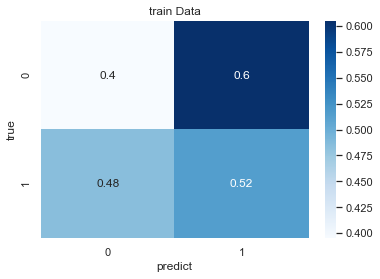

In [27]:
print_result(train_confusion_matrix, "train Data")

## test data

In [28]:
test_data_path  = "..\Case_Presentation_1_Data\Test_Intuitive\\"
test_data  = dataloader(test_data_path)
score=0
test_ans = []

for text in test_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        test_ans.append(0)
    else:
        test_ans.append(1)
    score=0

In [29]:
test_y_true = test_data.label_list
test_y_pred = test_ans

test_confusion_matrix = confusion_matrix(test_y_true, test_y_pred)
tmp = numpy.empty((2,2), dtype=float)

for i in range(2):
    for j in range(2):
        tmp[i][j] = float(test_confusion_matrix[i][j])/200
test_confusion_matrix = tmp

precision:  0.42
recall:  0.49122807017543857
F1-Score:  0.4528301886792453


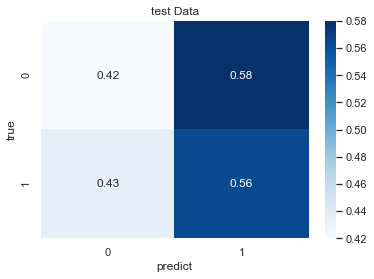

In [30]:
print_result(test_confusion_matrix, "test Data")